# Plot Simulation Variations

This notebook visualizes the effect of varying key MRS simulation parameters on the resulting spectra.  
It is used to generate Figure 5 in the manuscript.

### Included Parameter Variations
- **Noise** levels
- **Lipid** contamination (amplitude and linewidth)
- **Shim** imperfections (field inhomogeneity amplitude and correlation length)
- **Water** contamination amplitude

Each subplot displays a single randomly selected spectrum

## Imports

In [1]:
# === General-purpose libraries ===
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from fsl_mrs.utils.mrs_io import read_FID
import shutil
import sys

# === Set up the project root directory ===
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(PROJECT_ROOT)


# === Local utilities ===
from utils.loading import list_spectra_in_folder


## Styling Config

In [2]:
# === Matplotlib configuration ===
# Check if LaTeX is installed for better rendering
latex_installed = shutil.which('latex') is not None

BASE_SIZE = 16  # Base font size for plots

# Configure plot fonts and sizes
plt.rcParams.update({
    'text.usetex': latex_installed,
    'font.family': 'serif' if latex_installed else 'DejaVu Sans',
    'font.size': BASE_SIZE,
    'axes.titlesize': BASE_SIZE * 1.2,
    'axes.labelsize': BASE_SIZE * 1.1,
    'xtick.labelsize': BASE_SIZE * 0.9,
    'ytick.labelsize': BASE_SIZE * 0.9,
    'legend.fontsize': BASE_SIZE * 0.95,
    'figure.titlesize': BASE_SIZE * 1.3,
})


## Load Spectra

In [3]:
# === Load total spectra for each parameter group ===
lipid_path = './outputs/simulation_var_lipid'
noise_path = './outputs/simulation_var_noise'
shim_path  = './outputs/simulation_var_shim'
water_path = './outputs/simulation_var_water'

# Load files indexed by simulation ID and type
lipid_files = list_spectra_in_folder(lipid_path, possible_components=['total'])
noise_files = list_spectra_in_folder(noise_path, possible_components=['total'])
shim_files  = list_spectra_in_folder(shim_path,  possible_components=['total'])
water_files = list_spectra_in_folder(water_path, possible_components=['total'])

In [4]:
# === Helper function to load simulated spectra and metadata ===
def load_specs(files):
    specs = []
    for sim_id, components in tqdm(files.items(), desc="Loading spectra"):
        for path in components['components'].values():
            nii = read_FID(path)
            mrs = nii.mrs()
            spec = mrs.get_spec()
            ppm = mrs.getAxes('ppmshift')

            # Load simulation parameters from accompanying config
            dirname = os.path.dirname(path)
            config_file = os.path.join(dirname, 'sim_params.json')
            with open(config_file, 'r') as f:
                config = json.load(f)

            specs.append({
                'spec': spec,
                'ppm': ppm,
                'config': config,
                'file': path
            })
    return specs


In [5]:
# === Sort based on parameter ===
specs_lipid = load_specs(lipid_files)
specs_noise = load_specs(noise_files)
specs_shim = load_specs(shim_files)
specs_water = load_specs(water_files)

Loading spectra: 100%|██████████| 20/20 [00:00<00:00, 903.99it/s]


## Plotting Function

In [6]:
def plot_categorical_variation_offset_single(
    ax, specs, param, title, param_values,
    offset=80, seed=9, ppm_range=(0, 6.5),
    fixed_params=None, label_offset=20
):
    """
    Plot vertically offset spectra grouped by a single simulation parameter.
    One random spectrum per parameter value is selected for clarity.

    Args:
        ax: Matplotlib axis to plot on.
        specs: List of spectrum dictionaries.
        param: The simulation parameter to vary (e.g., 'noise_level').
        title: Subplot title.
        param_values: List of expected values for the parameter.
        offset: Vertical offset between plots.
        seed: Random seed for reproducibility.
        ppm_range: Tuple for x-axis (ppm) range.
        fixed_params: Dict of parameters to fix for 2D variation control.
        label_offset: Offset for inline text labels.
    """
    
    random.seed(seed)
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(len(param_values))]
    color_map = dict(zip(param_values, colors))

    all_y_vals = []

    for i, val in enumerate(param_values):
        # Filter by main param
        group_specs = [s for s in specs if s['config']['simulation_params'][param] == val]

        # Further filter by fixed params
        if fixed_params:
            for key, fixed_val in fixed_params.items():
                group_specs = [s for s in group_specs if s['config']['simulation_params'].get(key) == fixed_val]

        if not group_specs:
            print(f"Warning: No spectra found for {param}={val} with fixed {fixed_params}")
            continue

        s = random.choice(group_specs)
        ydata = np.real(s['spec']) + i * offset
        ax.plot(s['ppm'], ydata, color=color_map[val], linewidth=1.5)
        all_y_vals.append(ydata)

        # Inline label
        ppm_label_pos = 6.0  # adjust to where the spectrum is flatter/less busy
        closest_idx = np.argmin(np.abs(s['ppm'] - ppm_label_pos))
        ax.text(
                s['ppm'][closest_idx], ydata[closest_idx] + label_offset,
                str(val),
                color=color_map[val],
                fontsize=14,
                va='center', ha='left',
                fontweight='bold',
                fontfamily='sans-serif'  # Optional but improves clarity
            )

    if not all_y_vals:
        return

    all_y_vals = np.concatenate(all_y_vals)
    y_min, y_max = np.min(all_y_vals), np.max(all_y_vals)
    y_margin = 0.05 * (y_max - y_min)

    ax.set_title(title, fontsize=12)
    ax.set_xlim(ppm_range[::-1])
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    # ax.set_ylabel('Signal (a.u.)')
    ax.label_outer()
    ax.grid(True, linestyle='--', alpha=0.3)

### Define Parameter Values

These are the discrete values used to group and compare spectra in the variation plots.
They correspond to parameters defined in the simulation configuration files.

In [7]:
# === Define simulation parameter values used for grouping ===

# Noise contamination levels
noise_levels = [1.0, 5.0, 15.0, 25.0]

# Lipid contamination levels and linewidths
lipid_amp_factors = [5.0, 10.0, 20.0, 30.0]
lipid_sigmas = [2.5, 5.0, 7.5, 10.0]

# Shim imperfection settings
shim_amplitude_hzs = [1.0, 2.5, 4.0, 5.0]
shim_corr_length = [1.0, 2.0, 5.0, 10.0]

# Water contamination levels
water_amp_factor = [0.0, 5.0, 10.0, 15.0]

### Plot Variation Subplots

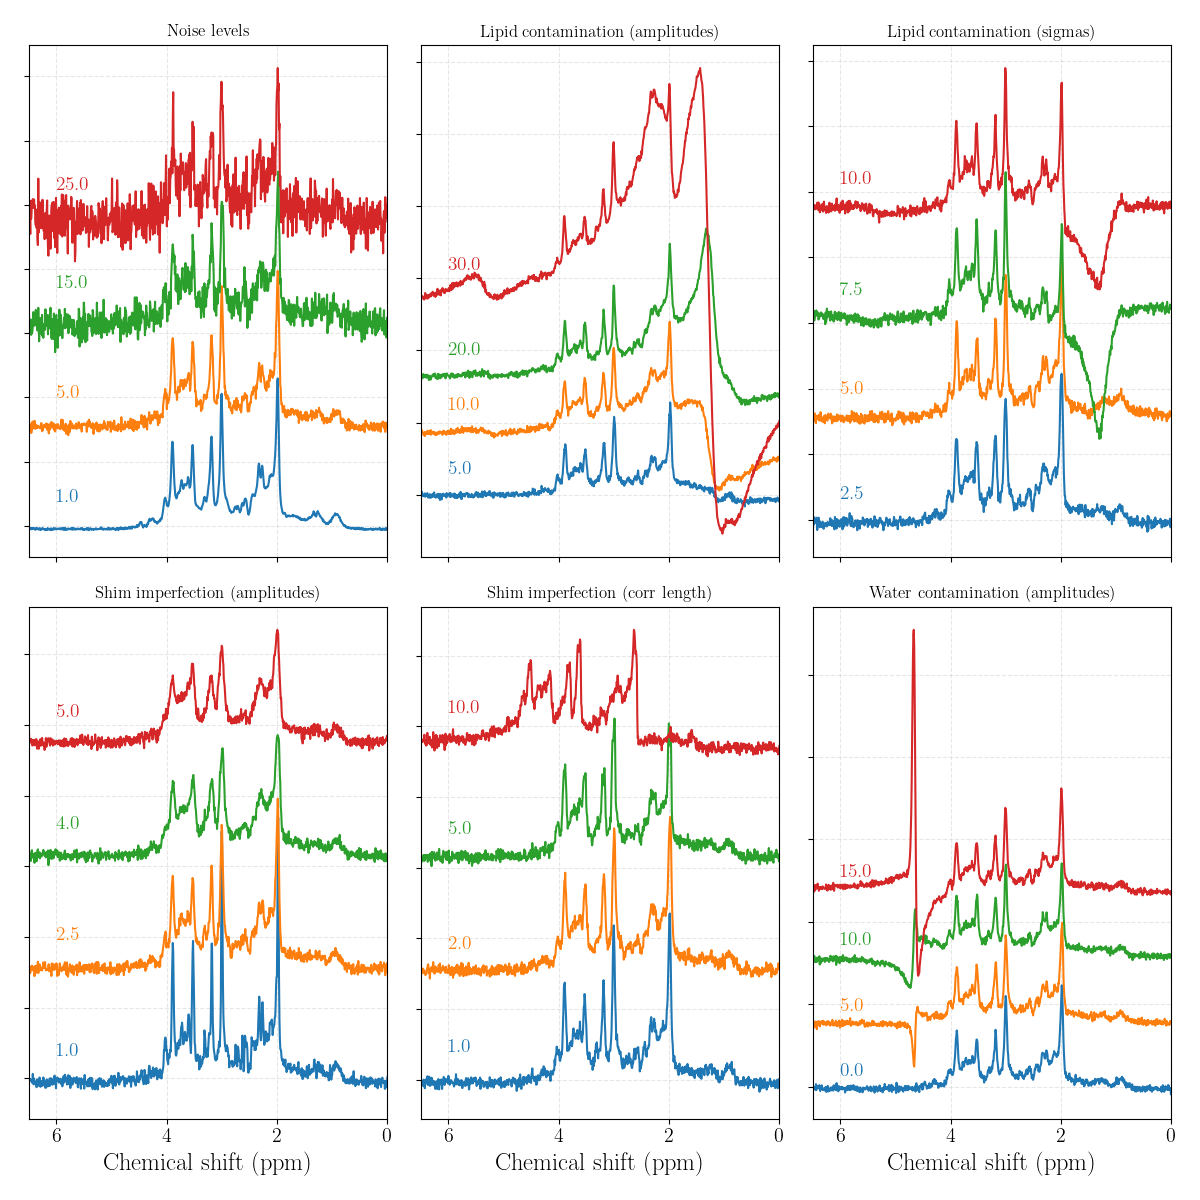

In [8]:
%matplotlib widget

# === Create figure and axes ===
fig, axs = plt.subplots(2, 3, figsize=(12, 12), sharex=True)
axs = axs.flatten()

# === Plot each type of variation ===
plot_categorical_variation_offset_single(
    axs[0], specs_noise, 'noise_level', 
    'Noise levels', noise_levels,
    label_offset=25,
)

plot_categorical_variation_offset_single(
    axs[1], specs_lipid, 'lipid_amp_factor',
    'Lipid contamination (amplitudes)', lipid_amp_factors,
    fixed_params={'lipid_sigma': 10.0},
    label_offset=35,
)

plot_categorical_variation_offset_single(
    axs[2], specs_lipid, 'lipid_sigma',
    'Lipid contamination (sigmas)', lipid_sigmas,
    fixed_params={'lipid_amp_factor': 10.0}
)

plot_categorical_variation_offset_single(
    axs[3], specs_shim, 'shim_amplitude_hz',
    'Shim imperfection (amplitudes)', shim_amplitude_hzs,
    fixed_params={'shim_corr_length': 1.0}
)

plot_categorical_variation_offset_single(
    axs[4], specs_shim, 'shim_corr_length',
    'Shim imperfection (corr length)', shim_corr_length,
    fixed_params={'shim_amplitude_hz': 2.5}
)

plot_categorical_variation_offset_single(
    axs[5], specs_water, 'water_amp_factor',
    'Water contamination (amplitudes)', water_amp_factor,
)

# === Customize axes ===
for i in [3, 4, 5]:
    axs[i].set_xlabel('Chemical shift (ppm)')

for ax in axs:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()
